In [1]:
import nbimporter
import numpy as np

import s03_01_hc_load_general as ld

import s04_07_a_kerosene_boiler as hs_oil
import s04_07_b_gas_boiler as hs_gas
import s04_07_c_electric_heater as hs_eheater
import s04_07_d_electric_heatpump as hs_ehpump
import s04_07_e_hybrid_hw_gas_ht_hybrid as hs_gas_hybrid
import s04_07_f_hybrid_hw_hybrid_ht_gas as hs_hybrid_gas
import s04_07_g_hybrid_hw_hybrid_ht_hybrid as hs_whybrid
import s04_07_n as hs_ghpump

import s04_07_j_panel_radiator as rad_panel
import s04_07_k_fan_convector as rad_fanc
import s04_07_l_hot_water_floor_heating as rad_floor

import s04_07_i_pipe as pipe

from s04_07_common import get_Q_out_H_hs_d_t

from s11_01_external_condition import \
    load_outdoor, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex, \
    get_Theta_ex_a_Ave, \
    get_Theta_ex_d_Ave_d, \
    get_Theta_ex_H_Ave

## Á¨¨‰∏ÉÁØÄ„ÄÄÊ∏©Ê∞¥ÊöñÊàø / Section 7 Hot Water Heating

1ÔºéÈÅ©Áî®ÁØÑÂõ≤ÔΩû4ÔºéË®òÂè∑Âèä„Å≥Âçò‰Ωç„ÅØÁúÅÁï•

1. Scope of application ~ 4. Symbols and units are omitted

### 5. ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ / Maximum heating output

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊöñÊàøË®≠ÂÇôÊ©üÂô®Á≠â„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ$Q_{max,H,d,t,i}$„ÅØ„ÄÅÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ$Q_{max,H,rad,d,t,i}$„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã„ÄÇ 

Maximum heating output $ Q_{max, H, d, t, i} $ of heating equipment installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $ is $ $ It is assumed that the maximum heating output $ Q_{max, H, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at time $ t $ of d $.

In [2]:
def calc_Q_max_H_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type):
    """ ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ

    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param A_HCZ: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂ∫äÈù¢Á©ç
    :type A_HCZ: float
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    :type Theta_SW: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :rtype: ndarray
    """
    return calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type)


### 6. „Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè / Energy consumption

#### 6.1 Ê∂àË≤ªÈõªÂäõÈáè / Power consumption

$$
\large
E_{E,H,d,t} = E_{E,hs,d,t} + \sum_{i} (E_{E,rad,d,t,i})
$$

$E_{E,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∂àË≤ªÈõªÂäõÈáè(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$E_{E,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè(kWh/h) / Power consumption of the hot water heating heater per hour at time $ t $ on date $ d $  
$E_{E,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∂àË≤ªÈõªÂäõÈáè(kWh/h) / Power consumption of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $    

In [3]:
def calc_E_E_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, L_CS_x_t, L_CL_x_t, CG=None):
    """ Ê∂àË≤ªÈõªÂäõÈáè (1)

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param L_CS_x_t: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑
    :type L_CS_x_t: ndarray
    :param L_CL_x_t: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑
    :type L_CL_x_t: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥Ë®≠ÂÇô„ÅÆ‰ªïÊßò
    :type CG: dict
    :return: Ê∂àË≤ªÈõªÂäõÈáè (1)
    :rtype: ndarray
    """
    rad_types = get_rad_type_list()

    rad_list = get_rad_list(H_MR, H_OR)

    E_E_hs_d_t = calc_E_E_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t, L_CL_x_t)

    E_E_rad_d_t = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is None:
            continue
        if rad_list[i - 1]['type'] in rad_types:
            radiator = rad_list[i - 1]
            R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
            mode = mode_MR if i == 1 else mode_OR
            A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)

            Theta_SW_hs_op = get_Theta_SW_hs_op(H_HS['type'], CG)
            p_hs_d_t = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
            Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs_d_t)
            Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW_d_t, region, mode, R_type)
            Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

            E_E_rad_d_t_i = calc_E_E_rad_d_t_i(i, radiator, Q_T_H_rad_d_t_i, Theta_SW_d_t, A_A, A_MR, A_OR, region, mode,
                                               R_type)
            E_E_rad_d_t[i - 1, :] = E_E_rad_d_t_i

            # print('{} E_E_rad_d_t_{} = {} [KWh] (L_T_H_rad_d_t_{} = {} [MJ])'.format(radiator['type'], i,
            #                                                                          np.sum(E_E_rad_d_t_i), i,
            #                                                                          np.sum(L_T_H_rad[i - 1])))

    E_E_H_d_t = E_E_hs_d_t + np.sum(E_E_rad_d_t, axis=0)

    return E_E_H_d_t

#### 6.2 ÁÅØÊ≤πÊ∂àË≤ªÈáè / Kerosene consumption

$$
\large
E_{K,H,d,t} = E_{K,hs,d,t}
$$

$E_{K,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè(MJ/h) / Kerosene consumption per hour at time $ t $ of date $ d $  
$E_{K,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè(MJ/h) / Kerosene consumption of the heat source machine for hot water heating per hour at the time $ t $ of date $ d $ 

In [4]:
def calc_E_K_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ ÁÅØÊ≤πÊ∂àË≤ªÈáè (2)

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: ÁÅØÊ≤πÊ∂àË≤ªÈáè (2)
    :rtype: ndarray
    """
    return calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

#### 6.3 „Ç¨„ÇπÊ∂àË≤ªÈáè / Gas consumption

$$
\large
E_{G,H,d,t} = E_{G,hs,d,t}
$$

$E_{G,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè(MJ/h) / Gas consumption per hour at time $ t $ of date $ d $  
$E_{G,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè(MJ/h) / Gas consumption of the hot water heating heat source machine per hour at time $ t $ of date $ d $  

In [5]:
def calc_E_G_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ „Ç¨„ÇπÊ∂àË≤ªÈáè (3)

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: „Ç¨„ÇπÊ∂àË≤ªÈáè (3)
    :rtype: ndarray
    """
    return calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

#### 6.4 „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè / Primary energy consumption by other fuels

$$
\large
E_{M,H,d,t} = E_{M,hs,d,t}
$$

$E_{M,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè(MJ/h) / Primary energy consumption by other fuels per hour at time $ t $ on date $ d $  
$E_{M,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè(MJ/h) / Primary energy consumption by the other fuels of the hot water heating heat source unit per hour at time $ t $ of date $ d $  

In [6]:
def calc_E_M_H_d_t(H_HS):
    """ „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè (4)

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :return: „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè (4)
    :rtype: ndarray
    """
    return get_E_M_hs_d_t(H_HS)

### 7. Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè / Energy consumption of heat source equipment for hot water heating

In [7]:
def calc_Q_UT_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t_i, L_CL_x_t_i):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊú™Âá¶ÁêÜ

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :param L_CS_x_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ (MJ/h)
    :type L_CS_x_t_i: ndarray
    :param L_CL_x_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ (MJ/h)
    :type L_CL_x_t_i: ndarray
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊú™Âá¶ÁêÜ
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ
    rad_list = get_rad_list(H_MR, H_OR)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    # Âá¶ÁêÜÊöñÊàøË≤†Ëç∑
    Q_T_H_rad = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
        Q_T_H_rad[i - 1, :] = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    r_WS_hs = calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW_d_t, region, A_A, A_MR, A_OR, mode_MR)

    if hs_type in ['Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:

        # ÂÆöÊ†ºÂäπÁéá
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_oil.get_e_rtd_default(hs_type)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_oil.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_oil.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type in ['„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:

        # ÂÆöÊ†ºÂäπÁéá
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_gas.get_e_rtd_default(hs_type)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # ÊúÄÂ§ßÂá∫Âäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÊúÄÂ§ßÂá∫Âäõ
        Q_max_H_hs_d_t = hs_eheater.calc_Q_max_H_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # ÂÆöÊ†º„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_ehpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # Â§ñÊ∞óÊù°‰ª∂„ÅÆÂèñÂæó
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # ÊúÄÂ§ßÂá∫Âäõ
        Q_max_H_hs_d_t = hs_ehpump.calc_Q_max_H_hs(
            q_rtd_hs=q_rtd_hs,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            h_ex=h_ex
        )

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return np.zeros(24 * 365)
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':
        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return np.zeros(24 * 365)
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        return np.zeros(24 * 365)
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # Â§ñÊ∞óÊù°‰ª∂„ÅÆÂèñÂæó
        # Â§ñÊ∞óÊ∏©
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        Theta_ex_a_Ave = get_Theta_ex_a_Ave(Theta_ex)
        Theta_ex_d_Ave_d = get_Theta_ex_d_Ave_d(Theta_ex)
        Theta_ex_H_Ave = get_Theta_ex_H_Ave(Theta_ex, L_T_H_rad)

        # ÂÆöÊ†º„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÂÆöÊ†ºËÉΩÂäõ ‰ªòÈå≤H„Å´ÂÆö„ÇÅ„ÇãÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßËÉΩÂäõ q_max_hs „Å´Á≠â„Åó„ÅÑ
        q_rtd_hs = hs_ghpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

      # ÊúÄÂ§ßÂá∫Âäõ
        Q_max_H_hs_d_t = hs_ghpump.calc_Q_max_H_hs_d_t(
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_ex_d_Ave_d=Theta_ex_d_Ave_d,
            Theta_ex_H_Ave=Theta_ex_H_Ave,
            Theta_ex_a_Ave=Theta_ex_a_Ave,
            q_max_hs=q_rtd_hs,
            L_H_x_t_i=L_T_H_rad,
            L_CS_x_t_i=L_CS_x_t_i,
            L_CL_x_t_i=L_CL_x_t_i,
            HeatExchangerType=H_HS['HeatExchanger']
        )

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    else:
        raise ValueError(hs_type)

#### 7.1 „Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè / Energy consumption

ÁúÅÁï•

ommision

In [8]:
def calc_E_E_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t_i, L_CL_x_t_i):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :param L_CS_x_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ (MJ/h)
    :type L_CS_x_t_i: ndarray
    :param L_CL_x_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ (MJ/h)
    :type L_CL_x_t_i: ndarray
    :return: Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ
    rad_list = get_rad_list(H_MR, H_OR)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    # Âá¶ÁêÜÊöñÊàøË≤†Ëç∑
    Q_T_H_rad = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
        Q_T_H_rad[i - 1, :] = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    r_WS_hs = calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW_d_t, region, A_A, A_MR, A_OR, mode_MR)

    if hs_type in ['Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè
        E_K_hs = calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        E_E_hs = hs_oil.calc_E_E_hs(
            hs_type=hs_type,
            r_WS_hs=r_WS_hs,
            E_K_hs=E_K_hs
        )
    elif hs_type in ['„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè
        E_G_hs = calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        E_E_hs = hs_gas.calc_E_E_hs(
            r_WS_hs=r_WS_hs,
            E_G_hs=E_G_hs
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # ÊúÄÂ§ßÂá∫Âäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÊúÄÂ§ßÂá∫Âäõ
        Q_max_H_hs_d_t = hs_eheater.calc_Q_max_H_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        E_E_hs = hs_eheater.calc_E_E_hs(
            Q_out_H_hs=Q_out_H_hs_d_t,
            r_WS_hs=r_WS_hs
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # ÂÆöÊ†º„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_ehpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # Â§ñÊ∞óÊù°‰ª∂„ÅÆÂèñÂæó
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # ÊúÄÂ§ßÂá∫Âäõ
        Q_max_H_hs_d_t = hs_ehpump.calc_Q_max_H_hs(
            q_rtd_hs=q_rtd_hs,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            h_ex=h_ex
        )

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè (kWh/h)
        E_E_hs = hs_ehpump.calc_E_E_hs(
            Q_out_H_hs=Q_out_H_hs_d_t,
            Q_max_H_hs=Q_max_H_hs_d_t,
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            q_rtd_hs=q_rtd_hs
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        # Â§ñÊ∞óÊ∏©
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè (kWh/h)
        E_E_hs = hs_gas_hybrid.calc_E_E_hs(
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_RW_hs=Theta_RW_hs,
            Theta_ex=Theta_ex,
            h_ex=h_ex,
            Theta_SW_d_t=Theta_SW_d_t,
            TU_place=H_HS['TU_place']
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':
        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè (MJ/h)
        E_G_hs = calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè (kWh/h)
        E_E_hs = hs_hybrid_gas.calc_E_E_hs(
            r_WS_hs=r_WS_hs,
            E_G_hs=E_G_hs
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè (kWh/h)
        return hs_whybrid.get_E_E_hs()
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        # „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÂ†¥Âêà„ÅØÈõªÂäõ„ÇíË®à‰∏ä„Åó„Å™„ÅÑ
        return np.zeros(24 * 365)
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        # Â§ñÊ∞óÊ∏©
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        Theta_ex_a_Ave = get_Theta_ex_a_Ave(Theta_ex)
        Theta_ex_d_Ave_d = get_Theta_ex_d_Ave_d(Theta_ex)
        Theta_ex_H_Ave = get_Theta_ex_H_Ave(Theta_ex, L_T_H_rad)

        # ÂÆöÊ†º„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # ÂÆöÊ†ºËÉΩÂäõ ‰ªòÈå≤H„Å´ÂÆö„ÇÅ„ÇãÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßËÉΩÂäõ q_max_hs „Å´Á≠â„Åó„ÅÑ
        q_rtd_hs = hs_ghpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊ∂àË≤ªÈõªÂäõÈáè (kWh/h)
        E_E_hs = hs_ghpump.calc_E_E_hs_d_t(
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_ex_a_Ave=Theta_ex_a_Ave,
            Theta_ex_d_Ave_d=Theta_ex_d_Ave_d,
            Theta_ex_H_Ave=Theta_ex_H_Ave,
            Theta_SW_d_t=Theta_SW_d_t,
            q_max_hs=q_rtd_hs,
            L_H_x_t_i=L_T_H_rad,
            L_CS_x_t_i=L_CS_x_t_i,
            L_CL_x_t_i=L_CL_x_t_i,
            HeatExchangerType=H_HS['HeatExchanger']
        )
    else:
        raise ValueError(hs_type)

    # print('{} E_E_hs = {} [kwh]'.format(hs_type, np.sum(E_E_hs)))

    return E_E_hs


In [9]:
def get_rad_type_list():
    """ ÊîæÁÜ±Á≥ª„ÅÆÁ®ÆÈ°û

    :return: ÊîæÁÜ±Á≥ª„ÅÆÁ®ÆÈ°û
    :rtype: list
    """
    # ÊîæÁÜ±Á≥ª„ÅÆÁ®ÆÈ°û
    return [
        'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº',
        'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº',
        'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø'
    ]


def get_rad_list(H_MR, H_OR):
    """ ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ

    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :return: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :rtype: list
    """
    # ÊöñÊàøÂå∫Áîªi=1-5„Å´ÂØæÂøú„Åó„ÅüÊîæÁÜ±Âô®„ÅÆ„É™„Çπ„Éà„Çí‰ΩúÊàê
    rad_list = [None, None, None, None, None]

    # ÊîæÁÜ±Á≥ª„ÅÆÁ®ÆÈ°û
    rad_types = get_rad_type_list()

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§
    if H_MR is not None:
        if H_MR['type'] in rad_types:
            rad_list[0] = H_MR

    # „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§
    if H_OR is not None:
        if H_OR['type'] in rad_types:
            rad_list[1] = H_OR
            rad_list[2] = H_OR
            rad_list[3] = H_OR
            rad_list[4] = H_OR

    return rad_list

In [10]:
def calc_L_HWH(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÜ±Ë≤†Ëç∑

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÜ±Ë≤†Ëç∑
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ
    rad_list = get_rad_list(H_MR, H_OR)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    return Q_dmd_H_hs_d_t

In [11]:
def calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ
    rad_list = get_rad_list(H_MR, H_OR)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    if hs_type in ['Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:

        # ÂÆöÊ†ºÂäπÁéá
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_oil.get_e_rtd_default(hs_type)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_oil.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_oil.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ (9)
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR,
                                           L_T_H_rad)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè
        E_K_hs = hs_oil.calc_E_K_hs(
            Q_out_H_hs=Q_out_H_hs,
            e_rtd=e_rtd,
            hs_type=hs_type,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_RW_hs=Theta_RW_hs,
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )
    elif hs_type in ['„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        E_K_hs = hs_gas.get_E_K_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_K_hs = hs_eheater.get_E_K_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_K_hs = hs_ehpump.get_E_K_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        E_K_hs = hs_gas_hybrid.get_E_K_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':
        E_K_hs = hs_hybrid_gas.calc_E_K_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        E_K_hs = hs_whybrid.get_E_K_hs()
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        E_K_hs = np.zeros(24 * 365)
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_K_hs = hs_ghpump.get_E_K_hs_d_t()
    else:
        raise ValueError(hs_type)

    # print('{} E_K_hs = {} [MJ] (L_T_H_rad = {} [MJ])'.format(hs_type, np.sum(E_K_hs), np.sum(L_T_H_rad)))

    return E_K_hs

In [12]:
def calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :param H_MR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_MR: dict
    :param H_OR: ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
    :type H_OR: dict
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÅÑ„ÅÜÂçò‰Ωç„ÅßË®≠ÂÆö„Åï„Çå„ÅüÊîæÁÜ±Ê©üÂô®„ÇíÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó„Å´Â§âÊèõ
    rad_list = get_rad_list(H_MR, H_OR)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    if hs_type in ['Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        E_G_hs = hs_oil.get_E_G_hs()
    elif hs_type in ['„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:

        # ÂÆöÊ†ºÂäπÁéá
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_gas.get_e_rtd_default(hs_type)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ (W)
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        E_G_hs = hs_gas.calc_E_G_hs(
            e_rtd=e_rtd,
            q_rtd_hs=q_rtd_hs,
            Q_out_H_hs=Q_out_H_hs,
            hs_type=hs_type,
            P_hs=p_hs,
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_G_hs = hs_eheater.get_E_G_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_G_hs = hs_ehpump.get_E_G_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':

        # Â§ñÊ∞óÊ∏©
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A,
                                           A_MR, A_OR, region, mode_MR, mode_OR,
                                           L_T_H_rad)

        E_G_hs = hs_gas_hybrid.calc_E_G_hs(
            Theta_ex=Theta_ex,
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_RW_hs=Theta_RW_hs,
            TU_place=H_HS['TU_place'],
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # ÂÆöÊ†ºËÉΩÂäõ„ÅÆË®àÁÆó„ÅÆ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø„ÅÆÂèñÂæó
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # Ê∏©Ê∞¥ÊöñÊàøÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºËÉΩÂäõ
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        E_G_hs = hs_hybrid_gas.calc_E_G_hs(
            q_rtd_hs=q_rtd_hs,
            Q_out_H_hs=Q_out_H_hs,
            P_hs=p_hs
        )
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        E_G_hs = hs_whybrid.get_E_G_hs()
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        E_G_hs = np.zeros(24 * 365)
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        E_G_hs = hs_ghpump.get_E_G_hs_d_t()
    else:
        raise ValueError(hs_type)

    # print('{} E_G_hs = {} [MJ] (L_T_H_rad = {} [MJ])'.format(hs_type, np.sum(E_G_hs), np.sum(L_T_H_rad)))

    return E_G_hs

In [13]:
def get_E_M_hs_d_t(H_HS):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè

    :param H_HS: Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò
    :type H_HS: dict
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    if hs_type in ['Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        return hs_oil.get_E_M_hs()
    elif hs_type in ['„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü']:
        return hs_gas.get_E_M_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return hs_eheater.get_E_M_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return hs_ehpump.get_E_M_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return hs_gas_hybrid.get_E_M_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':
        return hs_hybrid_gas.calc_E_M_hs()
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return hs_whybrid.get_E_M_hs()
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        return np.zeros(24 * 365)
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return hs_ghpump.get_E_M_hs_d_t()
    else:
        raise ValueError(hs_type)

#### 7.2 ÊöñÊàøÂá∫Âäõ / Heating output

$$
\large
Q_{out,H,hs,d,t} = min(Q_{dmd,H,hs,d,t}, Q_{max,H,hs,d,t})
$$

$Q_{out,H,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ(MJ/h) / Heating output of the hot water heating heat source unit per hour at time $ t $ of date $ d $  
$Q_{max,H,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ(MJ/h) / Maximum heating output of the hot water heating heat source unit per hour at time $ t $ of date $ d $  
$Q_{dmd,H,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å(MJ/h) / Hot water heat demand of the hot water heating heat source unit per hour at time $ t $ of date $ d $  

$$
\large
Q_{dmd,H,hs,d,t} = \sum_{i} (Q_{dmd,H,ln,d,t,i})
$$

$Q_{dmd,H,ln,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Á≥ªÁµ±$i$„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å(MJ/h) / Hot water heat demand of heat dissipation system $ i $ per hour at time $ t $ of date $ d $  

In [14]:
def calc_Q_dmd_H_hs_d_t(rad_list, pipe_insulation, underfloor_pipe_insulation, Theta_SW_d_t, A_A, A_MR, A_OR, region,
                        mode_MR, mode_OR,
                        L_T_H_rad_d_t):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å (6)

    :param rad_list: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :type rad_list: list
    :param pipe_insulation: ÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: Â∫ä‰∏ãÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type underfloor_pipe_insulation: bool
    :param Theta_SW_d_t: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW_d_t: ndarray
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    :rtype: ndarray
    """
    MR_rad_type, r_Af_1 = get_MR_rad_type_and_r_Af_1(rad_list)

    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)

    Q_dmd_H_hs_d_t = np.zeros_like(Theta_SW_d_t)

    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
        Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad_d_t[i - 1])

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
        r_WS_rad_d_t_i = calc_r_WS_rad_d_t_i(
            A_HCZ=A_HCZ,
            radiator=rad_list[i - 1],
            Q_T_H_rad=Q_T_H_rad_d_t_i,
            Theta_SW=Theta_SW_d_t,
            region=region,
            mode=mode,
            R_type=R_type
        )

        Q_dmd_H_ln_d_t_i = calc_Q_dmd_H_ln_d_t_i(
            i=i,
            radiator=rad_list[i - 1],
            Q_T_H_rad_d_t_i=Q_T_H_rad_d_t_i,
            Q_max_H_rad_d_t_i=Q_max_H_rad_d_t_i,
            L_T_H_rad_d_t_i=L_T_H_rad_d_t[i - 1],
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            r_WS_rad_d_t_i=r_WS_rad_d_t_i,
            A_A=A_A,
            pipe_insulation=pipe_insulation,
            underfloor_pipe_insulation=underfloor_pipe_insulation,
            MR_rad_type=MR_rad_type,
            r_Af_1=r_Af_1
        )

        Q_dmd_H_hs_d_t = Q_dmd_H_hs_d_t + Q_dmd_H_ln_d_t_i

    return Q_dmd_H_hs_d_t

In [15]:
def get_MR_rad_type_and_r_Af_1(rad_list):
    """„ÄÄ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÊîæÁÜ±Ê©üÂô®„Å®ÂΩìË©≤‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊï∑Ë®≠Áéá (-)

    :param rad_list: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :type rad_list: list
    :return: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÊîæÁÜ±Ê©üÂô®„Å®ÂΩìË©≤‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊï∑Ë®≠Áéá (-)
    :rtype: tuple
    """
    if rad_list[0] is not None:
        MR_rad_type = rad_list[0]['type']
        if 'r_Af' in rad_list[0]:
            r_Af_1 = rad_list[0]['r_Af']
        else:
            r_Af_1 = None
    else:
        MR_rad_type = None
        r_Af_1 = None
    return MR_rad_type, r_Af_1

#### 7.3 Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate

$Q_{dmd,H,hs,d,t} > 0$ „ÅÆÂ†¥Âêà

If $ Q_{dmd, H, hs, d, t}> 0 $

$$\large
r_{WS,hs,d,t} = \left\{ \begin{array}{ll}
    r_{WS,ln,d,t,i}&(ÊîæÁÜ±Á≥ªÁµ±„Åå1Á≥ªÁµ±„ÅÆÂ†¥Âêà)\\ 
    1&(ÊîæÁÜ±Á≥ªÁµ±„Åå2Á≥ªÁµ±‰ª•‰∏ä„ÅÆÂ†¥Âêà)\\ 
    \end{array}
\right.
$$

$Q_{dmd,H,hs,d,t} = 0$ „ÅÆÂ†¥Âêà

If $Q_{dmd,H,hs,d,t} = 0$

$$\large
r_{WS,hs,d,t} = 0
$$

$r_{WS,hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate of the heat source machine for hot water heating at time $ t $ of date $ d $  
$r_{WS,ln,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊîæÁÜ±Á≥ªÁµ±$i$„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢ÁéáÔºà„Åü„Å†„Åó„ÄÅ„Åì„Åì„Åß„ÅØ$i=1$„Åß„ÅÇ„Çã„ÄÇÔºâ / Hot water supply operation rate of the heat dissipation system $ i $ at the time $ t $ of the date $ d $ (however, here, $ i = 1 $).   

In [16]:
def calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW, region, A_A, A_MR, A_OR, mode_MR):
    """„ÄÄÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá

    :param rad_list: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :type rad_list: list
    :param Q_dmd_H_hs_d_t:  1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÁÜ±ÈúÄË¶Å (MJ/h)
    :type Q_dmd_H_hs_d_t: ndarray
    :param Q_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad: ndarray
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW: ndarray
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param mode_MR: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :return:„ÄÄÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    :rtype: ndarray
    """
    # (7a)
    n = sum([rad is not None for rad in rad_list])  # ÊîæÁÜ±Á≥ªÁµ±Êï∞
    if n == 1:
        A_HCZ = calc_A_HCZ_i(1, A_A, A_MR, A_OR)
        radiator = rad_list[0]
        R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§'
        tmp = calc_r_WS_ln_d_t_i(A_HCZ, radiator, Q_T_H_rad[0], Theta_SW, region, mode_MR, R_type)
    elif n > 1:
        tmp = np.ones(24 * 365)
    else:
        raise ValueError(n)

    # (7b)
    tmp[Q_dmd_H_hs_d_t == 0] = 0

    return tmp


#### 7.4 ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ / Hot water temperature going forward

$\theta_{SW,hs,op,1} > \theta_{SW,hs,op,2} > \theta_{SW,hs,op,3}$  

$\theta_{SW,hs,op,p}$ÔºöÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú$p$(‚ÑÉ) / Hot water temperature candidate for hot water heating heat source machine $ p $  .

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„Å´„Åä„Åë„ÇãÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜÂèä„Å≥ÂÄôË£ú(‚ÑÉ)<br>Table: Classification and candidates of forward hot water temperature in hot water heating heat source equipment</div>

<table>
<thead>
<tr>
<th colspan="2" rowspan="2">Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁ®ÆÈ°û<br>Kind of heat source machine for hot water heating</th>
<th colspan="3">ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú„ÅÆÂå∫ÂàÜ $p$<br>Classification $p$ of candidates for going hot water temperature</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>3</th>
</tr>
</thead>

<tbody>
<tr>
<th rowspan="2">Áü≥Ê≤πÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅÁü≥Ê≤πÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>Oil hot water heater, oil hot water heater hot water heater</th>
<th>ÂæìÊù•Âûã<br>Conventional type</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<th>ÊΩúÁÜ±ÂõûÂèéÂûã<br>Latent heat recovery type</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th rowspan="2">„Ç¨„ÇπÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅ„Ç¨„ÇπÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>Gas hot water heater, gas hot water heater hot water heater</th>
<th>ÂæìÊù•Âûã<br>Conventional type</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<th>ÊΩúÁÜ±ÂõûÂèéÂûã<br>Latent heat recovery type</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>Electric heater hot water heater, electric heater hot water hot water heater</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>Electric heat pump water heater</th>
<td>55</td>
<td>45</td>
<td>35</td>
</tr>

<tr>
<th colspan="2">ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>
ÔºàÁµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®Ôºâ <br>
Electric heat pump gas instantaneous type combined hot water water heater<br>(Hot-water supply heat source: gas moment type, heating heat source: electric heat pump, gas moment type combined use)</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>
ÔºàÁµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºèÔºâ<br>
Electric heat pump, gas instantaneous type combined hot water supply hot water heater<br>(Hot-water supply heat source: electric heat pump and gas moment type combined use, heating heat source: gas moment type)
</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü<br>
ÔºàÁµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅ<br>
ÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®Ôºâ<br>
Electric heat pump, gas instantaneous type combined hot water supply hot water heater<br>(Hot-water supply heat source: electric heat pump and gas moment type combined use, <br>heating heat source: electric heat pump and gas moment type combined use)</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥Ë®≠ÂÇô<br>Cogeneration equipment</th>
<td colspan="3">„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥Ë®≠ÂÇô„ÅÆÁ®ÆÈ°û„Å´‰æù„Çã<br>Depending on the type of cogeneration equipment</td>
</tr>

</tbody>
</table>


In [17]:
def get_Theta_SW_hs_op(hs_type, CG=None):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú

    :param hs_type: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÁ®ÆÈ°û
    :type hs_type: str
    :param CG: „Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„ÅÆÊ©üÂô®
    :type CG: dict
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú
    :rtype: tuple
    """
    if hs_type == 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'Áü≥Ê≤πÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return get_table_4()[0]
    elif hs_type == 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        ## TODO: ‰ªïÊßòÊõ∏‰∏ä„ÅØ40,60‚ÑÉ
        return (60,)
        return get_table_4()[1]
    elif hs_type == '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == '„Ç¨„ÇπÂæìÊù•ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == '„Ç¨„ÇπÂæìÊù•Âûã' or hs_type == 'G_NEJ':
        return get_table_4()[2]
    elif hs_type == '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûã' or hs_type == 'G_EJ':
        return get_table_4()[3]
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü' or hs_type == 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return get_table_4()[4]
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return get_table_4()[5]
    elif hs_type == 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü':
        return get_table_4()[6]
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return get_table_4()[7]
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºö„Ç¨„ÇπÁû¨ÈñìÂºè)(‰ªïÊßò„Å´„Çà„Çã)':
        return get_table_4()[8]
    elif hs_type == 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®ÂûãÁµ¶ÊπØÊ∏©Ê∞¥ÊöñÊàøÊ©ü(Áµ¶ÊπØÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®„ÄÅÊöñÊàøÁÜ±Ê∫êÔºöÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„Éó„Éª„Ç¨„ÇπÁû¨ÈñìÂºè‰ΩµÁî®)':
        return get_table_4()[9]
    elif hs_type == '„Ç≥„Éº„Ç∏„Çß„Éç„É¨„Éº„Ç∑„Éß„É≥„Çí‰ΩøÁî®„Åô„Çã':
        from s08_a_cgs_specification import get_type_BB_HWH
        if 'CG_category' in CG:
            type_BB_HWH = get_type_BB_HWH(CG['CG_category'])
        else:
            type_BB_HWH = CG['type_BB_HWH']
        return get_Theta_SW_hs_op(type_BB_HWH)
    elif hs_type == 'Áµ¶ÊπØ„ÉªÊ∏©Ê∞¥ÊöñÊàø‰∏Ä‰ΩìÂûã„Çí‰ΩøÁî®„Åô„Çã':
        raise NotImplementedError()
    else:
        raise ValueError(hs_type)


$$
\large
p_{hs,d,t} = min(p_{ln,d,t,1}, p_{ln,d,t,2}, ‚Ä¶ p_{ln,d,t,m})
$$

$p_{hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ(‚ÑÉ) / Division of the forward hot water temperature of the heat source machine for hot water heating at the time $ t $ on the date $ d $  
$p_{ln,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊîæÁÜ±Á≥ªÁµ±$i$„ÅÆË¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ(‚ÑÉ) / Division of heat dissipation system $ i $ at the time $ t $ of date $ d $  

In [18]:
def calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR):
    """ Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ (8)

    :param Theta_SW_hs_op: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú
    :type Theta_SW_hs_op: tuple
    :param rad_list: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :type rad_list: list
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :return: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ (8)
    :rtype: ndarray
    """
    p_ln = np.zeros((5, 24 * 365), dtype=np.int32)

    # ÂàùÊúüÂÄ§„Å®„Åó„Å¶„ÄÅÊúÄ‰ΩéÊ∏©Â∫¶„ÇíÊåáÂÆö
    p_ln[:] = len(Theta_SW_hs_op)

    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is not None:
            A_HCZ_i = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
            mode = mode_MR if i == 1 else mode_OR
            R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
            p_ln_i = calc_p_ln_d_t_i(rad_list[i - 1], L_T_H_rad[i - 1], Theta_SW_hs_op, A_HCZ_i, region, mode, R_type)
            p_ln[i - 1, :] = p_ln_i

    return np.min(p_ln, axis=0)


def get_Theta_SW_d_t(Theta_SW_hs_op, p_hs_d_t):
    """ Ë¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶

    :param Theta_SW_hs_op: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú
    :type Theta_SW_hs_op: tuple
    :param p_hs_d_t: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    :type p_hs_d_t: ndarray
    :return: Ë¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    :rtype: ndarray
    """
    # ‰∏ÄÊã¨Â§âÊèõÁî®„ÅÆndarray„Çí‰ΩúÊàê
    n = len(Theta_SW_hs_op)
    array_Theta_SW_hs_op = np.array(Theta_SW_hs_op).reshape((n, 1))

    # p_d_t„Å´Âü∫„Å•„ÅÑ„Å¶1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÇíÂèñÂæó
    Theta_SW_d_t = array_Theta_SW_hs_op[p_hs_d_t - 1]

    return Theta_SW_d_t.reshape(p_hs_d_t.shape)

def get_table_4():
    """ Ë°®4 Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„Å´„Åä„Åë„ÇãÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜÂèä„Å≥ÂÄôË£ú

    :return: Ë°®4 Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„Å´„Åä„Åë„ÇãÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜÂèä„Å≥ÂÄôË£ú
    :rtype: list
    """
    table_4 = [
        (60,),
        (60, 40),
        (60,),
        (60, 40),
        (60,),
        (55, 45, 35),
        (55, 45, 35),
        (60, 40),
        (60, 40),
        (60, 40),
    ]

    return table_4

#### 7.5 Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ / Return hot water temperature

$$\large
\theta_{RW,hs,d,t} = \left\{ \begin{array}{ll}
    0.0301 \times (T_{dif})^2 - 0.1864 \times T_{dif} + 20&(ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶\theta_{SW,hs} = 60)\\ 
    0.0604 \times (T_{dif})^2 - 0.1881 \times T_{dif} + 20&(ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶\theta_{SW,hs} = 40)\\ 
    \end{array}
\right.
$$

$$\large
T_{dif,d,t} = \frac{\sum_{i}Q_{dmd,H,ln,d,t,i}}{\sum_{i}Q'_{max,rad,d,t,i} \times  0.027583}
$$

$$\large
Q'_{max,H,rad,d,t,i} = \left\{ \begin{array}{ll}
    Q_{max,H,rad,d,t,i}&(Q_{ln,dmd,d,t,i} > 0)\\ 
    0&(Q_{ln,dmd,d,t,i} = 0)\\ 
    \end{array}
\right.
$$

$T_{dif,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂØæÊï∞Âπ≥ÂùáÊ∏©Â∫¶Â∑Æ(‚ÑÉ) / Log average temperature difference at time $ t $ of date $ d $  
$Q_{dmd,H,ln,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Á≥ªÁµ±$i$„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å(MJ/h) / Hot water heat demand of heat dissipation system $ i $ per hour at time $ t $ of date $ d $  
$Q'_{max,H,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å„ÅåÁô∫Áîü„Åô„ÇãÂ†¥Âêà„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ(MJ/h) / Maximum heating power of radiator installed in heating / cooling section $ i $ when hot water heat demand occurs per hour at time $ t $ of date $ d $  
$Q_{max,H,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ(MJ/h) / Maximum heating power of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $  

In [19]:
def calc_Theta_RW_hs_d_t(Theta_SW_hs_d_t, rad_list, pipe_insulation, underfloor_pipe_insulation, A_A, A_MR, A_OR, region,
                         mode_MR, mode_OR,
                         L_T_H_rad):
    """ Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ (9)

    :param Theta_SW_hs_d_t: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶
    :type Theta_SW_hs_d_t: ndarray
    :param rad_list: ÊîæÁÜ±Ê©üÂô®„ÅÆÊöñÊàøÂå∫Áîª„Åî„Å®„ÅÆÈÖçÂàó
    :type rad_list: list
    :param pipe_insulation: ÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: Â∫ä‰∏ãÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type underfloor_pipe_insulation: bool
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_MR: str
    :param mode_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode_OR: str
    :param L_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad: ndarray
    :return: Êàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ (9)
    :rtype: ndarray
    """
    MR_rad_type, r_Af_1 = get_MR_rad_type_and_r_Af_1(rad_list)

    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)

    Q_dmd_H_ln_d_t = np.zeros((5, 24 * 365))
    Q_dash_max_H_rad_d_t = np.zeros((5, 24 * 365))

    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is None:
            continue
        else:
            if rad_list[i - 1] is None:
                continue

            # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
            A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
            R_type = '‰∏ª„Åü„ÇãÂ±ÖÂÆ§' if i == 1 else '„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§'
            mode = mode_MR if i == 1 else mode_OR
            Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_hs_d_t, region, mode, R_type)

            # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
            Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

            # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
            r_WS_rad_d_t_i = calc_r_WS_rad_d_t_i(
                A_HCZ=A_HCZ,
                radiator=rad_list[i - 1],
                Q_T_H_rad=Q_T_H_rad_d_t_i,
                Theta_SW=Theta_SW_hs_d_t,
                region=region,
                mode=mode,
                R_type=R_type
            )

            Q_dmd_H_ln_d_t[i - 1] = calc_Q_dmd_H_ln_d_t_i(
                i=i,
                radiator=rad_list[i - 1],
                Q_T_H_rad_d_t_i=Q_T_H_rad_d_t_i,
                Q_max_H_rad_d_t_i=Q_max_H_rad_d_t_i,
                L_T_H_rad_d_t_i=L_T_H_rad[i - 1],
                Theta_SW_d_t=Theta_SW_hs_d_t,
                Theta_ex=Theta_ex,
                r_WS_rad_d_t_i=r_WS_rad_d_t_i,
                A_A=A_A,
                pipe_insulation=pipe_insulation,
                underfloor_pipe_insulation=underfloor_pipe_insulation,
                MR_rad_type=MR_rad_type,
                r_Af_1=r_Af_1
            )

            Q_dash_max_H_rad_d_t_i = get_Q_dash_max_H_rad_d_t_i(Q_max_H_rad_d_t_i, Q_dmd_H_ln_d_t[i - 1])
            Q_dash_max_H_rad_d_t[i - 1, :] = Q_dash_max_H_rad_d_t_i

    # 1ÊôÇÈñì„Åî„Å®„ÅÆÂØæÊï∞Âπ≥ÂùáÊ∏©Â∫¶Â∑Æ (9b)
    T_dif = get_T_dif_d_t(Q_dmd_H_ln_d_t, Q_dash_max_H_rad_d_t)

    # Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÊàª„ÇäÊ∏©Ê∞¥Ê∏©Â∫¶ (9a)
    Theta_RW_hs_d_t = np.zeros(24 * 365)

    # - Êù°‰ª∂1 (ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶60Â∫¶)
    f1 = (Theta_SW_hs_d_t == 60)
    Theta_RW_hs_d_t[f1] = 0.0301 * T_dif[f1] ** 2 - 0.1864 * T_dif[f1] + 20

    # - Êù°‰ª∂2 (ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶40Â∫¶)
    f2 = (Theta_SW_hs_d_t == 40)
    Theta_RW_hs_d_t[f2] = 0.0604 * T_dif[f2] ** 2 - 0.1881 * T_dif[f2] + 20

    # Ê∏©Ê∞¥ÊöñÊàøÁî®Êàª„ÇäÊ∏©Â∫¶„ÅØÂæÄ„ÅçÊ∏©Â∫¶„ÇíË∂Ö„Åà„Å™„ÅÑ
    fover = (Theta_RW_hs_d_t > Theta_SW_hs_d_t)  # Ê∏©Ê∞¥ÊöñÊàøÁî®Êàª„ÇäÊ∏©Â∫¶„ÅØÂæÄ„ÅçÊ∏©Â∫¶„ÇíË∂Ö„Åà„ÅüÊó•ÊôÇ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ
    Theta_RW_hs_d_t[fover] = Theta_SW_hs_d_t[fover]  # ÈÄÜËª¢Êó•ÊôÇ„ÅÆÈôê„Çä„ÄÅÊàª„ÇäÊ∏©Â∫¶=ÂæÄ„ÅçÊ∏©Â∫¶„Å®„Åô„Çã

    return Theta_RW_hs_d_t

In [20]:
def get_Q_dash_max_H_rad_d_t_i(Q_max_H_rad_d_t_i, Q_dmd_H_ln_d_t_i):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å„ÅåÁô∫Áîü„Åô„ÇãÂ†¥Âêà„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ (9c)

    :param Q_max_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :type Q_max_H_rad_d_t_i: ndarray
    :param Q_dmd_H_ln_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊîæÁÜ±Á≥ªÁµ±„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    :type Q_dmd_H_ln_d_t_i: ndarray
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å„ÅåÁô∫Áîü„Åô„ÇãÂ†¥Âêà„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ (9c)
    :rtype: ndarray
    """
    Q_dash_max_H_rad_d_t_i = np.copy(Q_max_H_rad_d_t_i)
    Q_dash_max_H_rad_d_t_i[Q_dmd_H_ln_d_t_i == 0] = 0
    return Q_dash_max_H_rad_d_t_i

In [21]:
def get_T_dif_d_t(Q_dmd_H_ln_d_t, Q_dash_max_H_rad_d_t):
    """ 1ÊôÇÈñì„Åî„Å®„ÅÆÂØæÊï∞Âπ≥ÂùáÊ∏©Â∫¶Â∑Æ (9b)

    :param Q_dmd_H_ln_d_t: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Á≥ªÁµ±„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    :type Q_dmd_H_ln_d_t: ndarray
    :param Q_dash_max_H_rad_d_t: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :type Q_dash_max_H_rad_d_t: ndarray
    :return: 1ÊôÇÈñì„Åî„Å®„ÅÆÂØæÊï∞Âπ≥ÂùáÊ∏©Â∫¶Â∑Æ (9b)
    :rtype: ndarray
    """
    Q_dmd = np.sum(Q_dmd_H_ln_d_t, axis=0)
    Q_dash_max = np.sum(Q_dash_max_H_rad_d_t, axis=0)

    T_dif_d_t = np.zeros(24 * 365)
    f = (Q_dmd > 0)
    T_dif_d_t[f] = Q_dmd[f] / (Q_dash_max[f] * 0.027583)

    return T_dif_d_t

### 8. ÊîæÁÜ±Á≥ªÁµ± / Heat dissipation system

#### 8.1 Ê∏©Ê∞¥ÁÜ±ÈúÄË¶Å / Hot water heat demand

$$
\large
Q_{dmd,H,ln,d,t,i} = Q_{dmd,H,rad,d,t,i} + Q_{loss,pp,d,t,i}
$$

$Q_{dmd,H,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å(MJ/h) / Hot water heat demand of radiator installed in heating and cooling section $ i $ per hour at time $ t $ of date $ d $  
$Q_{loss,pp,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈÖçÁÆ°$i$„ÅÆÁÜ±ÊêçÂ§±(MJ/h) / Heat loss of piping $ i $ per hour at time $ t $ of date $ d $  

In [22]:
def calc_Q_dmd_H_ln_d_t_i(i, radiator, Q_T_H_rad_d_t_i, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i, Theta_SW_d_t, Theta_ex,
                          r_WS_rad_d_t_i, A_A, pipe_insulation, underfloor_pipe_insulation,
                          MR_rad_type, r_Af_1):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Á≥ªÁµ±i„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å (10)

    :param i: ÊöñÂÜ∑ÊàøÂå∫Áîªi
    :type i: int
    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_T_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad_d_t_i: ndarray
    :param Q_max_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :type Q_max_H_rad_d_t_i: ndarray
    :param L_T_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad_d_t_i: ndarray
    :param Theta_SW_d_t: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex: Â§ñÊ∞óÁµ∂ÂØæÊ∏©Â∫¶[K]
    :type Theta_ex: ndarray
    :param r_WS_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    :type r_WS_rad_d_t_i: ndarray
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param pipe_insulation: ÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: Â∫ä‰∏ãÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type underfloor_pipe_insulation: bool
    :param MR_rad_type: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÊîæÁÜ±Âô®„ÅÆÁ®ÆÈ°û
    :type MR_rad_type: str
    :param r_Af_1: ÂΩìË©≤‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊï∑Ë®≠Áéá (-)
    :type r_Af_1: float
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊîæÁÜ±Á≥ªÁµ±i„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å (10)
    :rtype: ndarray
    """
    # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    Q_dmd_H_rad_d_t_i = calc_Q_dmd_H_rad_d_t_i(radiator, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i)

    # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈÖçÁÆ°i„ÅÆÁÜ±ÊêçÂ§±
    Q_loss_pp_d_t_i = calc_Q_loss_pp_d_t_i(
        i=i,
        Theta_SW_d_t=Theta_SW_d_t,
        Theta_ex_d_t=Theta_ex,
        r_WS_rad_d_t_i=r_WS_rad_d_t_i,
        A_A=A_A,
        pipe_insulation=pipe_insulation,
        underfloor_pipe_insulation=underfloor_pipe_insulation,
        MR_rad_type=MR_rad_type,
        r_Af_1=r_Af_1
    )

    return Q_dmd_H_rad_d_t_i + Q_loss_pp_d_t_i

#### 8.2 Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate

$$
\large
r_{WS,ln,d,t,i} = r_{WS,rad,d,t,i}
$$

$r_{WS,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate of radiator installed in heating / cooling section $ i $ at time $ t $ of date $ d $  

In [23]:
def calc_r_WS_ln_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type):
    """ ÊîæÁÜ±Á≥ªÁµ±i„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá (11)

    :param A_HCZ: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂ∫äÈù¢Á©ç
    :type A_HCZ: float
    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad: ndarray
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW: ndarray
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: ÊîæÁÜ±Á≥ªÁµ±i„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá (11)
    :rtype: tuple
    """
    return calc_r_WS_rad_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type)

#### 8.3 Ë¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ / Classification of demand and warm water temperature

ÁúÅÁï•

ommision

In [24]:
def calc_p_ln_d_t_i(radiator, L_T_H_rad_d_t_i, Theta_SW_hs_op, A_HCZ, region, mode, R_type):
    """ ÊîæÁÜ±Á≥ªÁµ±„ÅÆË¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ

    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param L_T_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad_d_t_i: ndarray
    :param Theta_SW_hs_op: Ê∏©Ê∞¥ÊöñÊàøÁî®ÁÜ±Ê∫êÊ©ü„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú
    :type Theta_SW_hs_op: tuple
    :param A_HCZ: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂ∫äÈù¢Á©ç
    :type A_HCZ: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: ÊîæÁÜ±Á≥ªÁµ±„ÅÆË¶ÅÊ±ÇÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ
    :rtype: float
    """
    n = len(Theta_SW_hs_op)
    if n == 1:
        # ÂÄôË£ú„Åå1„Å§„ÅÆÂ†¥Âêà„ÅØÊ±∫ÂÆö
        return np.ones(24 * 365)
    else:
        # ÂÄôË£ú„Åå2„Å§‰ª•‰∏ä„ÅÆÂ†¥Âêà„ÅØÊú™Âá¶ÁêÜË≤†Ëç∑„ÅÆÁô∫ÁîüÁä∂Ê≥Å„ÇíÁ¢∫Ë™ç

        # ÊîæÁÜ±Âô®„Åå„Å™„ÅÑÊöñÊàøÂå∫Áîª„ÅåÊåáÂÆö„Åï„Çå„Å¶Â†¥Âêà„ÅØ‰æøÂÆú‰∏ä„ÄÅÊúÄ‰Ωé„ÅÆÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂå∫ÂàÜ„ÇíËøî„Åô
        if radiator is None:
            return n * np.ones(24 * 365)

        # ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú„Åî„Å®„Å´Êú™Âá¶ÁêÜË≤†Ëç∑„ÅÆÁô∫ÁîüÁä∂Ê≥Å„ÇíÁ¢∫Ë™ç„Åô„Çã
        # „Åì„ÅÆ„Å®„Åç„ÄÅÊúÄÂ§ß„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£ú(p=1)„ÅØÁ¢∫Ë™ç„Çí„Åó„Å™„ÅÑ
        flag_UT_d_t_p = np.ones((n - 1, 24 * 365))  # Âü∫Êú¨„ÅØp=1
        for p in range(2, n + 1):
            # ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£úp
            Theta_SW = Theta_SW_hs_op[p - 1]

            # ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£úp„Å´„Åä„Åë„ÇãÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÂá∫Âäõ
            Q_max_H_rad_d_t_i_p = calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type)

            # ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£úp„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
            Q_T_H_rad_d_t_i_p = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i_p, L_T_H_rad_d_t_i)

            # ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£úp„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑
            Q_UT_H_rad_d_t_i_p = L_T_H_rad_d_t_i - Q_T_H_rad_d_t_i_p

            # Êú™Âá¶ÁêÜË≤†Ëç∑„ÅåÁô∫Áîü„Åó„Å™„Åã„Å£„ÅüÊôÇÂàª„Å´„ÅØp„Çí‰øùÂ≠ò
            flag_UT_d_t_i_p = Q_UT_H_rad_d_t_i_p <= 0.0
            flag_UT_d_t_p[p - 2][flag_UT_d_t_i_p] = p

        # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶„ÅÆÂÄôË£úp
        p_ln_d_t_i = np.max(flag_UT_d_t_p, axis=0)
        return p_ln_d_t_i

### 9. ÈÖçÁÆ° / Plumbing

$$\large
Q_{loss,pp,d,t,i} = ((\theta_{SW,d,t} - (\theta_{ex,d,t} \times 0.7 + 20 \times 0.3)) \times L_{pp,ex,i} + (\theta_{SW,d,t} - 20) \times L_{pp,in,i})\\
\large
\times K_{loss,pp,i} \times r_{WS,rad,d,t,i} \times 3600 \times 10^{-6}
$$

$\theta_{SW,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶(‚ÑÉ) / Hot water temperature at time $ t $ with date $ d $    
$\theta_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ) / Outside temperature at time $ t $ of date $ d $  
$L_{pp,ex,i}$ÔºöÈÖçÁÆ°$i$„ÅÆÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Å´„Åä„Åë„ÇãÈï∑„Åï(m) / Length outside the adiabatic section of piping $ i $  
$L_{pp,in,i}$ÔºöÈÖçÁÆ°$i$„ÅÆÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„Å´„Åä„Åë„ÇãÈï∑„Åï(m) / Length in the adiabatic section of piping $ i $  
$K_{loss,pp,i}$ÔºöÈÖçÁÆ°$i$„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞(W/mK) / Line heat loss coefficient of piping $ i $  
$r_{WS,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate of radiator installed in heating / cooling section $ i $ at time $ t $ of date $ d $   

In [25]:
def calc_Q_loss_pp_d_t_i(i, Theta_SW_d_t, Theta_ex_d_t, r_WS_rad_d_t_i, A_A, pipe_insulation, underfloor_pipe_insulation,
                         MR_rad_type, r_Af_1):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈÖçÁÆ°i„ÅÆÁÜ±ÊêçÂ§± (12)

    :param i: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÁï™Âè∑
    :type i: int
    :param Theta_SW_d_t: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex_d_t: Â§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ)
    :type Theta_ex_d_t: ndarray
    :param r_WS_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    :type r_WS_rad_d_t_i: ndarray
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param pipe_insulation: ÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: Â∫ä‰∏ãÈÖçÁÆ°Êñ≠ÁÜ±„ÅÆÊúâÁÑ°
    :type underfloor_pipe_insulation: bool
    :param MR_rad_type: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÊîæÁÜ±Âô®„ÅÆÁ®ÆÈ°û
    :type MR_rad_type: str
    :param r_Af_1: ÂΩìË©≤‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÊï∑Ë®≠Áéá (-)
    :type r_Af_1: float
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈÖçÁÆ°i„ÅÆÁÜ±ÊêçÂ§± (12)
    :rtype: ndarray
    """
    # ÈÖçÁÆ°„ÅÆÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Å´„Åä„Åë„ÇãÈï∑„Åï
    L_pp_ex_i = pipe.calc_L_pp_ex_i(i, A_A, underfloor_pipe_insulation, MR_rad_type, r_Af_1)

    # ÈÖçÁÆ°„ÅÆÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„Å´„Åä„Åë„ÇãÈï∑„Åï
    L_pp_in_i = pipe.calc_L_pp_in_i(i, A_A, underfloor_pipe_insulation, MR_rad_type, r_Af_1)

    # Á∑öÁÜ±ÊêçÂ§±‰øÇÊï∞
    K_loss_pp_i = pipe.get_K_loss_pp(pipe_insulation)

    return ((Theta_SW_d_t - (Theta_ex_d_t * 0.7 + 20 * 0.3)) * L_pp_ex_i + (Theta_SW_d_t - 20) * L_pp_in_i) \
           * K_loss_pp_i * r_WS_rad_d_t_i * 3600 * 10 ** (-6)

### 10. ÊîæÁÜ±Âô® / Radiator

#### 10.1 ‰æõÁµ¶ÁÜ±Èáè / Heat supply

$$\large
Q_{dmd,H,rad,d,t,i} = Q_{T,H,rad,d,t,i} + Q_{loss,rad,d,t,i}
$$

$Q_{T,H,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑(MJ/h) / Processing heating load of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $  
$Q_{loss,rad,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÁÜ±ÊêçÂ§±(MJ/h) / Heat loss of radiator installed in heating / cooling compartment $ i $ per hour at time $ t $ of date $ d $  

In [26]:
def calc_Q_dmd_H_rad_d_t_i(radiator, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å (13)

    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_max_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :type Q_max_H_rad_d_t_i: ndarray
    :param L_T_H_rad_d_t_i: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊöñÊàøË≤†Ëç∑
    :type L_T_H_rad_d_t_i: ndarray
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥ÁÜ±ÈúÄË¶Å
    :rtype: ndarray
    """
    # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i)

    # 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÁÜ±ÊêçÂ§±
    Q_loss_rad_d_t_i = calc_Q_loss_rad_d_t_i(radiator, Q_T_H_rad_d_t_i)

    return Q_T_H_rad_d_t_i + Q_loss_rad_d_t_i

#### 10.2 Ê∂àË≤ªÈõªÂäõÈáè / Power consumption

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∂àË≤ªÈõªÂäõÈáè$E_{E,rad,d,t,i}$„ÅØ„ÄÅÊîæÁÜ±Âô®„ÅÆÁ®ÆÈ°û„Åå„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„ÉºÂèà„ÅØÊ∏©Ê∞¥Â∫äÊöñÊàø„ÅÆÂ†¥Âêà„ÅØ0„Å®„Åô„Çã„ÄÇ

The power consumption $ E_{E, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at the time $ t $ of the date $ d $ is the type of radiator When it is a panel radiator or hot-water floor heating, it is 0.

In [27]:
def calc_E_E_rad_d_t_i(i, radiator, Q_T_H_rad, Theta_SW, A_A, A_MR, A_OR, region, mode, R_type):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∂àË≤ªÈõªÂäõÈáè

    :param i: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÁï™Âè∑
    :type i: int
    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad: ndarray
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW: ndarray
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊ∂àË≤ªÈõªÂäõÈáè
    :rtype: ndarray
    """
    if radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº' or radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø':
        return np.zeros(24 * 365)
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº':

        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)

        return rad_fanc.calc_E_E_rad(
            A_HCZ=A_HCZ,
            region=region,
            mode=mode,
            R_type=R_type,
            Theta_SW=Theta_SW,
            Q_T_H_rad=Q_T_H_rad,
        )
    else:
        raise ValueError(radiator['type'])

In [28]:
def calc_A_HCZ_i(i, A_A, A_MR, A_OR):
    """ ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©ç

    :param i: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÁï™Âè∑
    :type i: int
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®à (m2)
    :type A_A: float
    :param A_MR: ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_MR: float
    :param A_OR: „Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç (m2)
    :type A_OR: float
    :return: ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©ç
    :rtype: float
    """
    return ld.get_A_HCZ_i(i, A_A, A_MR, A_OR)

#### 10.3 ÁÜ±ÊêçÂ§± / Heat loss

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÁÜ±ÊêçÂ§±$Q_{loss,rad,d,t,i}$„ÅØ„ÄÅÊîæÁÜ±Âô®„ÅÆÁ®ÆÈ°û„Åå„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„ÉºÂèà„ÅØ„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº„ÅÆÂ†¥Âêà„ÅØ0„Å®„Åô„Çã„ÄÇ

The heat loss $ Q_{loss, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at the time $ t $ of the date $ d $ has the type of radiator In the case of panel radiator or fan control vector, it is 0.

In [29]:
def calc_Q_loss_rad_d_t_i(radiator, Q_T_H_rad):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÁÜ±ÊêçÂ§±

    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad: ndarray
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÁÜ±ÊêçÂ§±
    :rtype: ndarray
    """
    if radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº' or radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº':
        return np.zeros_like(Q_T_H_rad)
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø':
        return rad_floor.get_Q_loss_rad(
            r_up=radiator['r_up'],
            Q_T_H_rad=Q_T_H_rad
        )
    else:
        raise ValueError(radiator['type'])

#### 10.4 Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá / Hot water supply operation rate

ÁúÅÁï•

ommision

In [30]:
def calc_r_WS_rad_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type):
    """ ÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá

    :param A_HCZ: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂ∫äÈù¢Á©ç
    :type A_HCZ: float
    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param Q_T_H_rad: ÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :type Q_T_H_rad: ndarray
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW: ndarray
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: ÊîæÁÜ±Âô®„ÅÆÊ∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá
    :rtype: ndarray
    """
    if radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº':
        # Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá„ÅÆË®àÁÆó
        r_WS_rad_d_t_i = rad_panel.calc_r_WS_rad(
            region=region,
            mode=mode,
            A_HCZ=A_HCZ,
            R_type=R_type,
            Theta_SW=Theta_SW,
            Q_T_H_rad=Q_T_H_rad
        )
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº':
        # ‰ªïÊßò„ÅÆÂèñÂæó
        q_max_FC = rad_fanc.calc_q_max_FC(region, mode, A_HCZ, R_type)
        q_min_FC = rad_fanc.get_q_min_FC(q_max_FC)
        Q_min_H_FC = rad_fanc.get_Q_min_H_FC(Theta_SW, q_min_FC)

        # Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá„ÅÆË®àÁÆó
        r_WS_rad_d_t_i = rad_fanc.get_r_WS_rad(
            Q_min_H_FC=Q_min_H_FC,
            Q_T_H_rad=Q_T_H_rad
        )
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø':
        # ‰ªïÊßò„ÅÆÂèñÂæó
        A_f = rad_floor.get_A_f(A_HCZ, radiator['r_Af'])
        Q_max_H_rad = rad_floor.get_Q_max_H_rad(Theta_SW, A_f)

        # Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá„ÅÆË®àÁÆó
        r_WS_rad_d_t_i = rad_floor.get_r_WS_rad(
            Q_T_H_rad=Q_T_H_rad,
            Q_max_H_rad=Q_max_H_rad
        )
    else:
        raise ValueError(radiator['type'])

    # Ê∏©Ê∞¥‰æõÁµ¶ÈÅãËª¢Áéá„Åå1„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„ÅØ1„ÄÅ0„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ0
    r_WS_rad_d_t_i = np.clip(r_WS_rad_d_t_i, 0, 1)

    return r_WS_rad_d_t_i

#### 10.5 Âá¶ÁêÜÊöñÊàøË≤†Ëç∑ / Processing heating load

ÁúÅÁï•

ommision

In [31]:
def calc_Q_T_H_rad_d_t_i(Q_max_H_d_t_i, L_H_d_t_i):
    """ 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑

    :param Q_max_H_d_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªùëñ„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :type Q_max_H_d_t_i: ndarray
    :param L_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :type L_H_d_t_i: ndarray
    :return: 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊîæÁÜ±Âô®„ÅÆÂá¶ÁêÜÊöñÊàøË≤†Ëç∑
    :rtype: ndarray
    """
    import s04_01_general_Q
    return s04_01_general_Q.get_Q_T_H_d_t_i(Q_max_H_d_t_i, L_H_d_t_i)

#### 10.6 ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ / Maximum heating output

ÁúÅÁï•

ommision

In [32]:
def calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type):
    """ ÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ

    :param radiator: ÊîæÁÜ±Âô®‰ªïÊßò
    :type radiator: dict
    :param A_HCZ: ÊöñÂÜ∑ÊàøÂå∫Áîª„ÅÆÂ∫äÈù¢Á©ç
    :type A_HCZ: float
    :param Theta_SW: ÂæÄ„ÅçÊ∏©Ê∞¥Ê∏©Â∫¶ (‚ÑÉ)
    :type Theta_SW: ndarray
    :param region: ÁúÅ„Ç®„Éç„É´„ÇÆ„ÉºÂú∞ÂüüÂå∫ÂàÜ
    :type region: int
    :param mode: ÈÅãËª¢„É¢„Éº„Éâ '„ÅÑ', '„Çç', '„ÅØ'
    :type mode: str
    :param R_type: Â±ÖÂÆ§„ÅÆÂΩ¢Âºè
    :type R_type: string
    :return: ÊîæÁÜ±Âô®„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ
    :rtype: ndarray
    """
    if radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº':
        # ‰ªïÊßò„ÅÆÂèñÂæó
        q_max_rad = rad_panel.calc_q_max_rad(region, mode, A_HCZ, R_type)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ„ÅÆË®àÁÆó
        return rad_panel.get_Q_max_H_rad(
            q_max_rad=q_max_rad,
            Theta_SW=Theta_SW
        )
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº':
        # ‰ªïÊßò„ÅÆÂèñÂæó
        q_max_FC = rad_fanc.calc_q_max_FC(region, mode, A_HCZ, R_type)

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ„ÅÆË®àÁÆó
        return rad_fanc.calc_Q_max_H_rad(
            q_max_FC=q_max_FC,
            Theta_SW=Theta_SW
        )
    elif radiator['type'] == 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø':
        # ‰ªïÊßò„ÅÆÂèñÂæó
        A_f = rad_floor.get_A_f(A_HCZ, radiator['r_Af'])

        # ÊúÄÂ§ßÊöñÊàøÂá∫Âäõ„ÅÆË®àÁÆó
        return rad_floor.get_Q_max_H_rad(
            A_f=A_f,
            Theta_SW=Theta_SW
        )
    else:
        raise ValueError(radiator['type'])

## Ë©¶ÁÆó‰æã

In [33]:
def get_default_hot_water_heating():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
    H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº'}
    H_OR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº'}
    H_HS = {'type': 'Áü≥Ê≤πÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'e_rtd_hs': 0.82, 'pipe_insulation': True, 'underfloor_pipe_insulation': True}
    
    return house_base, H_MR, H_OR, H_HS
    

In [34]:
def calc_results(param, H_MR, H_OR, H_HS, HEX=None):

    if __name__ == "__main__":

        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import get_Q
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_cooling_load, \
              get_virtual_heating_devices, get_virtual_heatsource, calc_Q_UT_H_MR_d_t, calc_Q_UT_H_OR_d_t
        from s04_01_a_heating_method import calc_heating_mode


        region = param["region"]
        sol_region = None
        A_A = param["A_A"]
        A_MR = param["A_MR"]
        A_OR = param["A_OR"]
        A_env = param["A_env"]
        U_A = param["U_A"]
        eta_A_H = param["eta_A_H"]
        eta_A_C = param["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = None
        CG = None


        mode_C = 'Â±ÖÂÆ§„ÅÆ„Åø„ÇíÂÜ∑Êàø„Åô„ÇãÊñπÂºè'
        mode_H = 'Â±ÖÂÆ§„ÅÆ„Åø„ÇíÊöñÊàø„Åô„ÇãÊñπÂºè„Åß„Åã„Å§‰∏ª„Åü„ÇãÂ±ÖÂÆ§„Å®„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„Å®„ÇÇ„Å´Ê∏©Ê∞¥ÊöñÊàø„ÇíË®≠ÁΩÆ„Åô„ÇãÂ†¥Âêà„Å´Ë©≤ÂΩì„Åó„Å™„ÅÑÂ†¥Âêà'

        # Â∫äÈù¢Á©ç„ÅÆÂêàË®à„Å´ÂØæ„Åô„ÇãÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©ç„ÅÆÂêàË®à„ÅÆÊØî
        r_env = calc_r_env(method='ÂΩìË©≤‰ΩèÊà∏„ÅÆÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©çÁ≠â„ÇíÁî®„ÅÑ„Å¶Â§ñÁöÆÊÄßËÉΩ„ÇíË©ï‰æ°„Åô„ÇãÊñπÊ≥ï', A_env=A_env, A_A=A_A)

        # ÁÜ±ÊêçÂ§±‰øÇÊï∞
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # Êó•Â∞ÑÂèñÂæó‰øÇÊï∞
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # ÊöñÊàøÊñπÂºèÂèä„Å≥ÈÅãËª¢ÊñπÊ≥ï„ÅÆÂå∫ÂàÜ
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

        # ÂÆüË≥™ÁöÑ„Å™Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆ‰ªïÊßò„ÇíÂèñÂæó
        spec_HS = get_virtual_heatsource(region, H_HS)

        # ÂÜ∑ÊàøË≤†Ëç∑
        L_CS_x_t, L_CL_x_t = calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt,
                                                   underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)

        # ÊöñÊàøË≤†Ëç∑
        L_T_H_rad, _ = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR,
                              mode_OR=mode_OR, SHC=None)

        # „Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè
        E_E_H_d_t = calc_E_E_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, L_CS_x_t, L_CL_x_t, CG=None)
        E_G_H_d_t = calc_E_G_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)
        E_K_H_d_t = calc_E_K_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)
        E_M_H_d_t = calc_E_M_H_d_t(H_HS)


        # Êú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÇíÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§„Å´ÊèõÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆ‰øÇÊï∞
        alpha_UT_H_MR = get_alpha_UT_H_MR(region, mode_MR)
        alpha_UT_H_OR = get_alpha_UT_H_OR(region, mode_OR)


        # Êú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑
        Q_UT_H_MR_d_t = calc_Q_UT_H_MR_d_t(region, A_A, A_MR, A_OR, H_MR, H_OR, spec_HS, mode_MR, mode_OR, CG, L_T_H_rad)

        # „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑
        Q_UT_H_OR_d_t = calc_Q_UT_H_OR_d_t(region, A_A, A_MR, A_OR, H_MR, H_OR, spec_HS, mode_MR, mode_OR, CG,L_T_H_rad) \
                        if H_OR["type"] in ["Ê∏©Ê∞¥ÊöñÊàøÁî®„Éë„Éç„É´„É©„Ç∏„Ç®„Éº„Çø„Éº", "Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº", "Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø"] \
                        else np.zeros(24 * 365)


        # Êú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„Å´Êú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§„Å´ÊèõÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆ‰øÇÊï∞„ÇíÊéõ„Åë„Å¶ÂêàÁÆó
        Q_UT_rad = Q_UT_H_MR_d_t * alpha_UT_H_MR + Q_UT_H_OR_d_t * alpha_UT_H_OR
        E_UT_H_d_t =Q_UT_rad


        f_prim = get_f_prim()
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t

        print('E_H:{}MJ/y'.format(np.sum(E_H_d_t)))

        return E_H_d_t

In [35]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### Ë®àÁÆóÊù°‰ª∂1

- ÂàùÊúüÊù°‰ª∂„Åß„ÅÆË®àÁÆó

In [36]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()

_E_H_d_t_1 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:41909.17228605997MJ/y


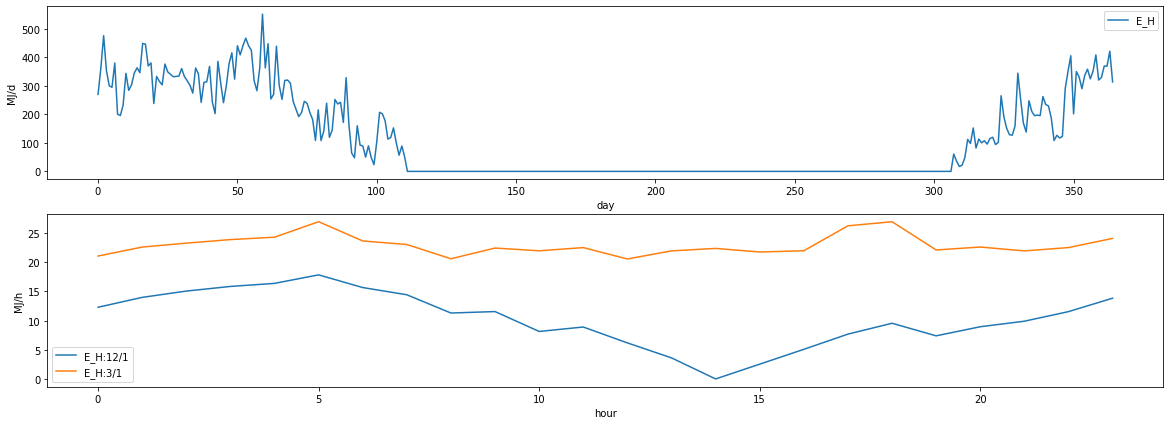

In [37]:
get_each_graph(_E_H_d_t_1)

### Ë®àÁÆóÊù°‰ª∂2

- ‰∏ªÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„ÇíÁü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü„Å´Â§âÊõ¥
- Êñ≠ÁÜ±ÈÖçÁÆ°„ÇíË©ï‰æ°„Åó„Å™„ÅÑ„Å´Â§âÊõ¥
- ÈÖçÁÆ°„ÅåÈÄöÈÅé„Åô„ÇãÁ©∫Èñì„ÇíË©ï‰æ°„Åó„Å™„ÅÑ„Å´Â§âÊõ¥

In [38]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR['type'] = 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº'
H_OR['type'] = 'Ê∏©Ê∞¥ÊöñÊàøÁî®„Éï„Ç°„É≥„Ç≥„É≥„Éô„ÇØ„Çø„Éº'
H_HS['type'] = 'Áü≥Ê≤πÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü'
del H_HS['e_rtd_hs']
H_HS['pipe_insulation'] = False
H_HS['underfloor_pipe_insulation'] = False

_E_H_d_t_2 = calc_results(house_base, H_MR, H_OR, H_HS)


E_H:19978.860846061947MJ/y


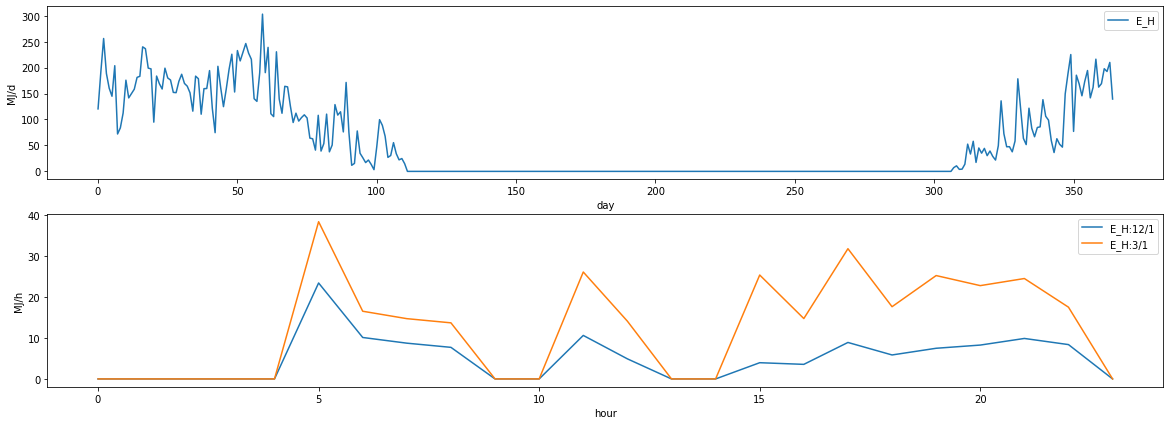

In [39]:
get_each_graph(_E_H_d_t_2)

### Ë®àÁÆóÊù°‰ª∂3

- ‰∏ªÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø„Å´Â§âÊõ¥
- ‰∏ªÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.3„ÄÅ‰ªÆÊÉ≥Â∫ä„ÅÆÂ∫äÈù¢Á©ç„ÇíÈô§„ÅÑ„ÅüÊï∑Ë®≠Áéá„Çí0.5„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.9„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.65„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.7„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„Çí„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí0.81„Å´Â§âÊõ¥

In [40]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.3, 'r_dash_Af': 0.5, 'r_up': 0.9}
H_OR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.65, 'r_up': 0.7}
H_HS = {'type': '„Ç¨„ÇπÂæìÊù•ÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü', 'e_rtd_hs': 0.81, 'pipe_insulation': True, 'underfloor_pipe_insulation': True}

_E_H_d_t_3 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:44175.389744659886MJ/y


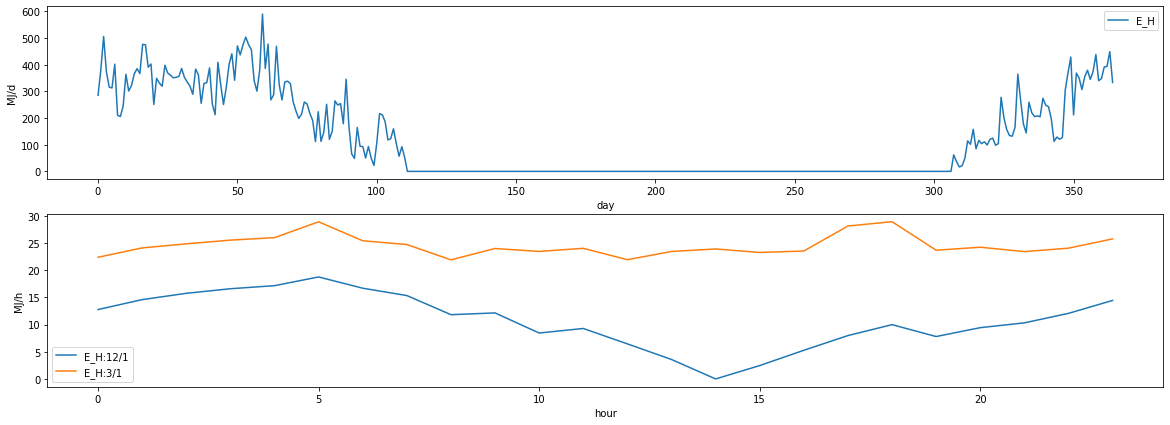

In [41]:
get_each_graph(_E_H_d_t_3)

### Ë®àÁÆóÊù°‰ª∂4

- ‰∏ªÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø„Å´Â§âÊõ¥
- ‰∏ªÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.4„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.9„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„Çí„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí„Äå„Çç„Äç„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„Çí„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí0.87„Å´Â§âÊõ¥

In [42]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': '„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº', 'e_class': '„Çç', 'dualcompressor': False}
H_HS['type'] = '„Ç¨„ÇπÊΩúÁÜ±ÂõûÂèéÂûãÊ∏©Ê∞¥ÊöñÊàøÊ©ü'
H_HS['e_rtd_hs'] = 0.87

_E_H_d_t_4 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:14408.10505746133MJ/y


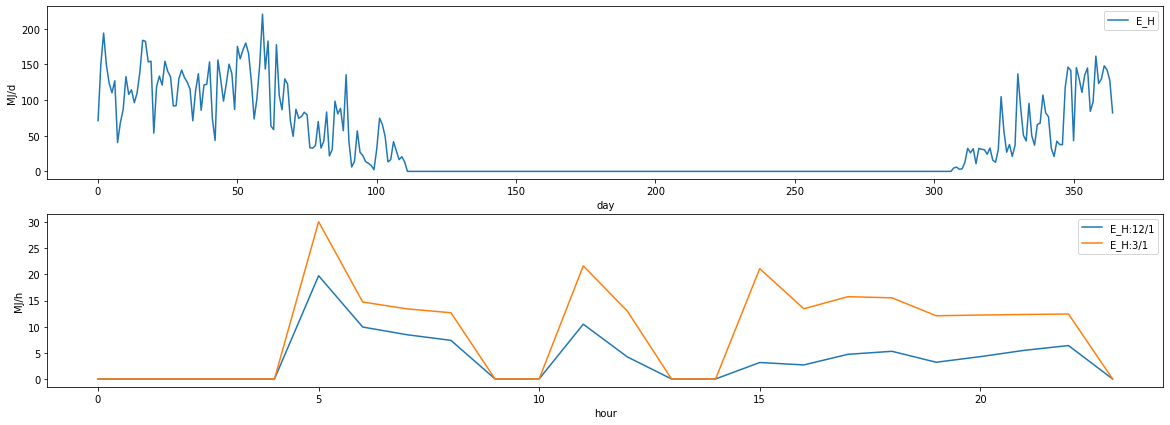

In [43]:
get_each_graph(_E_H_d_t_4)

### Ë®àÁÆóÊù°‰ª∂5

- ‰∏ªÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø„Å´Â§âÊõ¥
- ‰∏ªÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.4„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.9„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„Çí„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí„Äå„Çç„Äç„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„ÇíÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü„Å´Â§âÊõ¥

In [44]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': '„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº', 'e_class': '„Çç', 'dualcompressor': False}
H_HS['type'] = 'ÈõªÊ∞ó„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü'

_E_H_d_t_5 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:14716.370807563266MJ/y


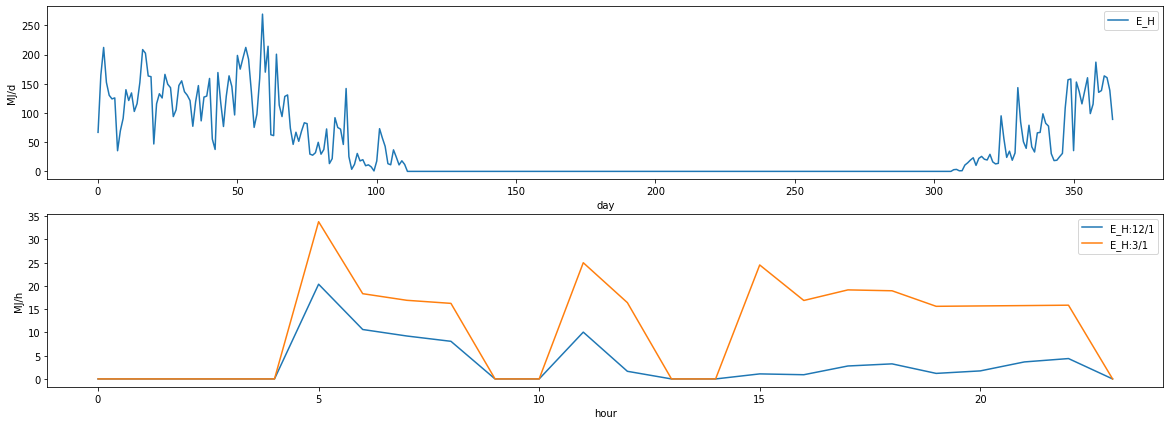

In [45]:
get_each_graph(_E_H_d_t_5)

### Ë®àÁÆóÊù°‰ª∂6

- ‰∏ªÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø„Å´Â§âÊõ¥
- ‰∏ªÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.4„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.9„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„Çí„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí„Äå„Çç„Äç„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„ÇíÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü„Å´Â§âÊõ¥

In [46]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': '„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº', 'e_class': '„Çç', 'dualcompressor': False}
H_HS['type'] = 'ÈõªÊ∞ó„Éí„Éº„Çø„ÉºÊ∏©Ê∞¥ÊöñÊàøÊ©ü'

_E_H_d_t_6 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:27521.5116359412MJ/y


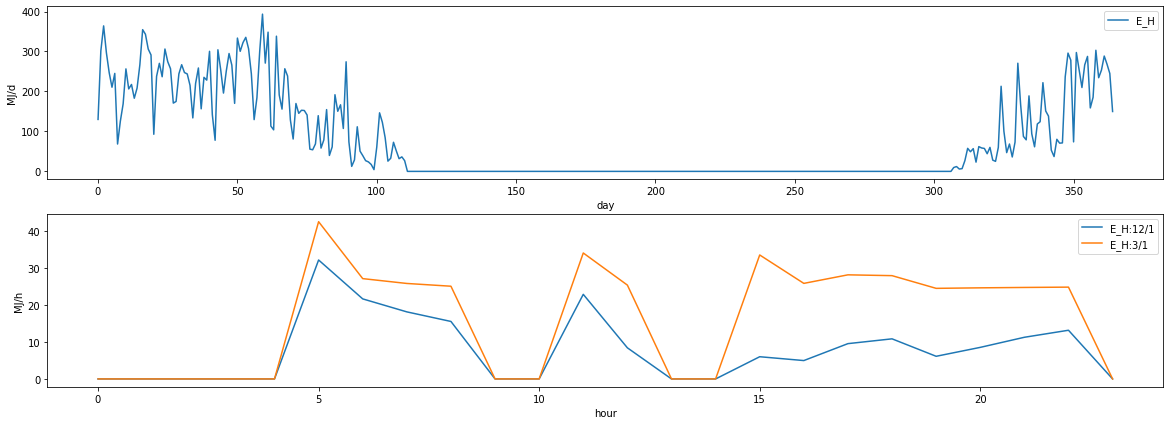

In [47]:
get_each_graph(_E_H_d_t_6)

### Ë®àÁÆóÊù°‰ª∂7

- ‰∏ªÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„ÇíÊ∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø„Å´Â§âÊõ¥
- ‰∏ªÂ±ÖÂÆ§„ÅÆÊï∑Ë®≠Áéá„Çí0.4„ÄÅ‰∏äÈù¢ÊîæÁÜ±ÁéáÔºàÂ∫ä„ÅÆÊñ≠ÁÜ±Ôºâ„Çí0.9„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÊöñÊàøË®≠ÂÇô„Çí„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº„Å´Â§âÊõ¥
- „Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆ„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÂäπÁéá„Çí„Äå„Çç„Äç„Å´Â§âÊõ¥
- Ê∏©Ê∞¥ÊöñÊàøÊ©ü„ÅÆÁ®ÆÈ°û„ÇíÂú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü„ÄÅÁÜ±‰∫§ÊèõÂô®„Çø„Ç§„Éó„Çí5„Å´Â§âÊõ¥

In [48]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': 'Ê∏©Ê∞¥ÊöñÊàøÁî®Â∫äÊöñÊàø', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': '„É´„Éº„É†„Ç®„Ç¢„Ç≥„É≥„Éá„Ç£„Ç∑„Éß„Éä„Éº', 'e_class': '„Çç', 'dualcompressor': False}
H_HS['type'] = 'Âú∞‰∏≠ÁÜ±„Éí„Éº„Éà„Éù„É≥„ÉóÊ∏©Ê∞¥ÊöñÊàøÊ©ü'
H_HS['HeatExchanger'] = '5'

_E_H_d_t_7 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:12911.713155884903MJ/y


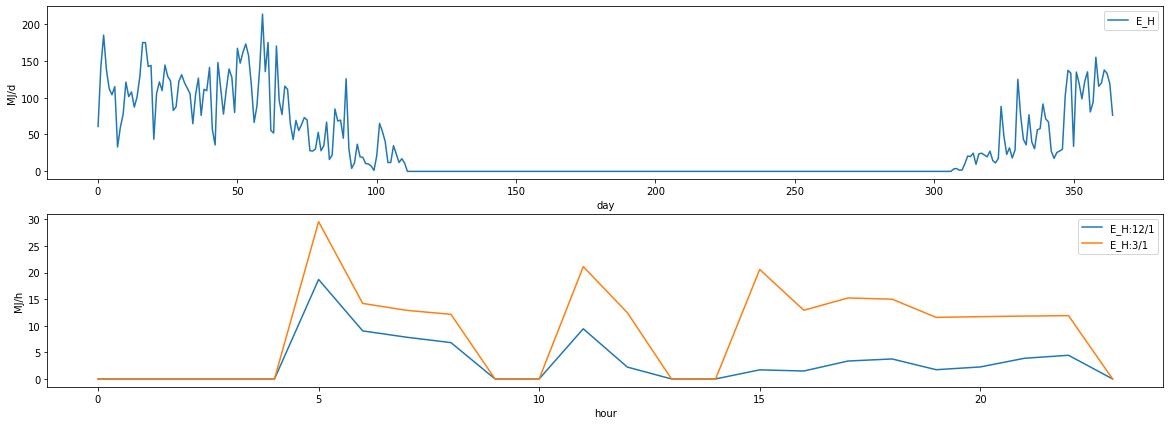

In [49]:
get_each_graph(_E_H_d_t_7)

## ÊØîËºÉ

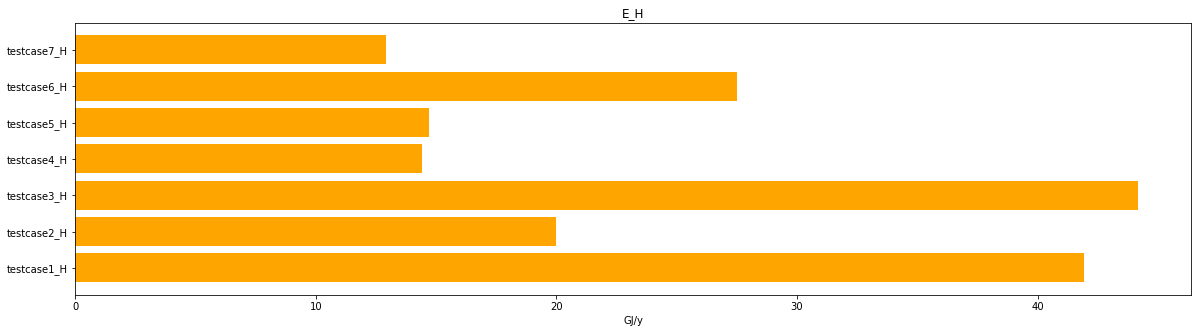

In [50]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testcase7_H": np.sum(_E_H_d_t_7)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()